# PREP

## TODO remove old code and repetitions

In [224]:
import os
import numpy as np
import math
import pandas as pd
import re
from functools import reduce
from collections import OrderedDict
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score
)
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

In [63]:
REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'
RESULTDIR = os.path.join(REPODIR, 'results')
# REPODIR = '/home/wimmerl/projects/wildlife-experiments'

CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
EMPTY_CLASS = LABEL_MAP['empty']
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'display_labels': list(LABEL_MAP.keys()),
    'xticks_rotation': 'vertical',
    'colorbar': False,
    'cmap': 'Blues',
}
THRESHOLDS = [0.3, 0.5, 0.7, 0.9]
OUR_THRESH = 0.5
ITERATIONS = list(range(9))[1:]
RANDOM_SEEDS = ['123', '456', '789']

In [7]:
# FILES_INSAMPLE = [
#     os.path.join(RESULTDIR, '0', f) for f in os.listdir(os.path.join(RESULTDIR, '0')) if 'insample_val' in f
# ]
# FILES_INSAMPLE = [os.path.join(RESULTDIR, f) for f in os.listdir(RESULTDIR) if 'insample_test' in f]
# RESULTS_INSAMPLE = [load_pickle(f) for f in FILES_INSAMPLE]
# THRESHOLDS = [0.1]

## DATA

In [64]:
FILES_INSAMPLE = [
    [os.path.join(RESULTDIR, t, f) for f in os.listdir(os.path.join(RESULTDIR, t)) if 'insample_test' in f] 
    for t in [str(int(100 * ts)) for ts in THRESHOLDS]
]
FILES_OOSAMPLE = [
    os.path.join(RESULTDIR, str(int(100 * OUR_THRESH)), f) 
    for f in os.listdir(os.path.join(RESULTDIR, str(int(100 * OUR_THRESH)))) 
    if 'oosample' in f 
]
FILES_ACTIVE_OPTIMAL = [
    os.path.join(RESULTDIR, f) for f in os.listdir(RESULTDIR) if 'active_optimal' in f 
]
# FILES_ACTIVE_COLDSTART = [
#     [os.path.join(RESULTDIR, 'coldstart', rs, f) for f in os.listdir(os.path.join(RESULTDIR, 'coldstart', rs))]
#     for rs in os.listdir(os.path.join(RESULTDIR, 'coldstart'))
# ]
FILES_ACTIVE_COLDSTART = [os.path.join(RESULTDIR, 'coldstart', 'entropy', rs) for rs in RANDOM_SEEDS]

In [4]:
# custom averaging functions accounting for specific ordering
def average_results(dict_list_preds, list_truth):
    ordered_dicts = [{k: d[k] for k in sorted(list(d.keys()))} for d in dict_list_preds]
    ordered_arrays = [
        np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(d.values())]) for d in ordered_dicts
    ]
    ordered_lists = [
        [x[k] for k in [list(d.keys()).index(i) for i in sorted(list(d.keys()))] ]
        for x, d in zip(list_truth, dict_list_preds)
    ]
    return reduce(np.add, ordered_arrays) / len(dict_list_preds), ordered_lists[0]

In [36]:
results_insample_avg = {}
results_oosample_avg = {}
results_active_optimal_avg = {}
results_active_coldstart_avg = {}

for idx, t in enumerate(THRESHOLDS):
    results_t = [load_pickle(f) for f in FILES_INSAMPLE[idx]]
#     results_t = [r[t] for r in RESULTS_INSAMPLE]
#     results_t = RESULTS_INSAMPLE
    preds_imgs_clf_t, truth_imgs_clf_t = average_results(
        [r['preds_imgs_clf'] for r in results_t], [r['truth_imgs_clf'] for r in results_t]
    )
    preds_imgs_ppl_t, truth_imgs_ppl_t = average_results(
        [r['preds_imgs_ppl'] for r in results_t], [r['truth_imgs_ppl'] for r in results_t]
    )
    results_insample_avg.update(
        {
            t: {
                'preds_imgs_clf': preds_imgs_clf_t,
                'preds_imgs_ppl': preds_imgs_ppl_t,
                'truth_imgs_clf': truth_imgs_clf_t,
                'truth_imgs_ppl': truth_imgs_ppl_t
                
            }
        }
    )
results_oos = [load_pickle(f) for f in FILES_OOSAMPLE]
preds_imgs_clf, truth_imgs_clf = average_results(
    [r['preds_imgs_clf'] for r in results_oos], [r['truth_imgs_clf'] for r in results_oos]
)
preds_imgs_ppl, truth_imgs_ppl = average_results(
    [r['preds_imgs_ppl'] for r in results_oos], [r['truth_imgs_ppl'] for r in results_oos]
)
results_oosample_avg.update(
    {
        'preds_imgs_clf': preds_imgs_clf,
        'preds_imgs_ppl': preds_imgs_ppl,
        'truth_imgs_clf': truth_imgs_clf,
        'truth_imgs_ppl': truth_imgs_ppl

    }
)
results_al_opt = [load_pickle(f) for f in FILES_ACTIVE_OPTIMAL]
preds_imgs_clf, truth_imgs_clf = average_results(
    [r['preds_imgs_clf'] for r in results_al_opt], [r['truth_imgs_clf'] for r in results_al_opt]
)
preds_imgs_ppl, truth_imgs_ppl = average_results(
    [r['preds_imgs_ppl'] for r in results_al_opt], [r['truth_imgs_ppl'] for r in results_al_opt]
)
results_active_optimal_avg.update(
    {
        'preds_imgs_clf': preds_imgs_clf,
        'preds_imgs_ppl': preds_imgs_ppl,
        'truth_imgs_clf': truth_imgs_clf,
        'truth_imgs_ppl': truth_imgs_ppl

    }
)
for t in ITERATIONS:
    results_t = [
        load_pickle(os.path.join(FILES_ACTIVE_COLDSTART[rs], f'results_iteration_{t}.pkl')) 
        for rs, _ in enumerate(RANDOM_SEEDS)
    ]
    preds_imgs_clf_t, truth_imgs_clf_t = average_results(
        [r['preds_imgs_clf'] for r in results_t], [r['truth_imgs_clf'] for r in results_t]
    )
    preds_imgs_ppl_t, truth_imgs_ppl_t = average_results(
        [r['preds_imgs_ppl'] for r in results_t], [r['truth_imgs_ppl'] for r in results_t]
    )
    results_active_coldstart_avg.update(
        {
            t: {
                'preds_imgs_clf': preds_imgs_clf_t,
                'preds_imgs_ppl': preds_imgs_ppl_t,
                'truth_imgs_clf': truth_imgs_clf_t,
                'truth_imgs_ppl': truth_imgs_ppl_t
                
            }
        }
    )

# IN-SAMPLE

In [55]:
# RESULTS_INSAMPLE_TEST_01 = load_pickle('results/202303010719_insample_test.pkl')
# RESULTS_INSAMPLE_VAL_01 = load_pickle('results/202303010719_insample_test.pkl')
# RESULTS_INSAMPLE_TEST_05 = load_pickle('results/202302280915_insample_test.pkl')
# RESULTS_INSAMPLE_VAL_05 = load_pickle('results/202302280915_insample_val.pkl')

## PERFORMANCE ACROSS THRESHOLDS ON TEST

Using varying thresholds for the MD, how well is our pipeline able to 1) classify images overall, 2) detect empty images correctly?

In [52]:
# RESULT_FILE = {**RESULTS_INSAMPLE_TEST_01, **RESULTS_INSAMPLE_TEST_05}
RESULT_FILE = results_insample_avg
PREDS = 'preds_imgs_ppl'
TRUTH = 'truth_imgs_ppl'

In [66]:
rows_multiclass = []
rows_empty = []

for t in sorted(THRESHOLDS):
    result = RESULT_FILE[t]
    y_true = result[TRUTH]
    y_pred = [np.argmax(v) for v in result[PREDS]]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )
    rows_multiclass.append(
        [
            t,
            report['accuracy'], 
            report['weighted avg']['precision'], 
            report['weighted avg']['recall'], 
            report['weighted avg']['f1-score']
        ]    
    )
    conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
    rows_empty.append(
        [
            t,
            (conf_empty[0][0, 0] + conf_empty[0][1, 1]) / conf_empty.sum(),
            report['empty']['precision'],
            report['empty']['recall'],
            report['empty']['f1-score'],
        ]
    )
df_ins_multiclass = pd.DataFrame(rows_multiclass, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])
df_ins_empty = pd.DataFrame(rows_empty, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])

In [99]:
def sort_results(dict_preds, truth):
    ordered_dict = {k: dict_preds[k] for k in sorted(list(dict_preds.keys()))}
    ordered_array = np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(ordered_dict.values())])
    ordered_list = [truth[k] for k in [list(dict_preds.keys()).index(i) for i in sorted(list(dict_preds.keys()))]]
    return ordered_array, ordered_list

In [100]:
rows_multiclass_avg, rows_multiclass_se = [], []
rows_empty_avg, rows_empty_se = [], []

for idx, t in enumerate(THRESHOLDS):
    results_t = [f for f in FILES_INSAMPLE[idx]]
    accs, precs, recs, fones = [], [], [], []
    accs_empty, precs_empty, recs_empty, fones_empty = [], [], [], []
    for rt in results_t:
        r = load_pickle(rt)
        preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl_t
        y_pred = [np.argmax(v) for v in preds_imgs_ppl_t]
        report = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            zero_division=0,
            output_dict=True,
        )
        accs.append(report['accuracy'])
        precs.append(report['weighted avg']['precision'])
        recs.append(report['weighted avg']['recall'])
        fones.append(report['weighted avg']['f1-score'])
        conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
        accs_empty.append((conf_empty[0][0, 0] + conf_empty[0][1, 1]) / conf_empty.sum())
        precs_empty.append(report['empty']['precision'])
        recs_empty.append(report['empty']['recall'])
        fones_empty.append(report['empty']['f1-score'])
    accs = np.array(accs)
    precs = np.array(precs)
    recs = np.array(recs)
    fones = np.array(fones)
    rows_multiclass_avg.append([t, np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)])
    rows_multiclass_se.append(
        [
            t,
            np.std(accs) / math.sqrt(len(accs)),
            np.std(precs) / math.sqrt(len(precs)),
            np.std(recs) / math.sqrt(len(recs)),
            np.std(fones) / math.sqrt(len(fones))
        ]
        
    )
    accs_empty = np.array(accs_empty)
    precs_empty = np.array(precs_empty)
    recs_empty = np.array(recs_empty)
    fones_empty = np.array(fones_empty)
    rows_empty_avg.append([t, np.mean(accs_empty), np.mean(precs_empty), np.mean(recs_empty), np.mean(fones_empty)])
    rows_empty_se.append(
        [
            t,
            np.std(accs_empty) / math.sqrt(len(accs_empty)),
            np.std(precs_empty) / math.sqrt(len(precs_empty)),
            np.std(recs_empty) / math.sqrt(len(recs_empty)),
            np.std(fones_empty) / math.sqrt(len(fones_empty))
        ]
        
    )
COLNAMES = ['threshold', 'acc', 'prec', 'rec', 'fone']
df_ins_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_ins_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)
df_ins_empty_avg = pd.DataFrame(rows_empty_avg, columns=COLNAMES)
df_ins_empty_se = pd.DataFrame(rows_empty_se, columns=COLNAMES)

In [101]:
df_ins_multiclass_avg

,threshold,acc,prec,rec,fone
0,0.3,0.926422,0.921628,0.926422,0.922216
1,0.5,0.924416,0.919696,0.924416,0.920191
2,0.7,0.928246,0.922879,0.928246,0.922998
3,0.9,0.922958,0.916711,0.922958,0.916285


In [102]:
df_ins_empty_avg

,threshold,acc,prec,rec,fone
0,0.3,0.952316,0.947133,0.980948,0.963743
1,0.5,0.949489,0.942551,0.981654,0.961696
2,0.7,0.952498,0.940072,0.989557,0.964179
3,0.9,0.949034,0.934266,0.990827,0.961715


In [67]:
df_ins_multiclass.sort_values('threshold')  # Table 3

,threshold,acc,prec,rec,fone
0,0.3,0.934081,0.930351,0.934081,0.930055
1,0.5,0.928337,0.924400,0.928337,0.924822
2,0.7,0.931619,0.926862,0.931619,0.926799
3,0.9,0.928884,0.924045,0.928884,0.922367


In [67]:
df_ins_empty.sort_values('threshold')  # Table 2

,threshold,acc,prec,rec,fone
0,0.3,0.955416,0.947862,0.985182,0.966162
1,0.5,0.950219,0.944173,0.980948,0.962209
2,0.7,0.953775,0.941603,0.989839,0.965119
3,0.9,0.951313,0.935060,0.993649,0.963465


## PERFORMANCE

In [189]:
def dict_mean(dict_list):
    mean_dict = {}
    list_k0 = list(dict_list[0].keys())
    accumulator0 = 0
    list_k1 = list(dict_list[0][list_k0[0]].keys())
    accumulator1 = [[0 for _ in list_k1] for _ in list_k0]
    for idx0 in range(len(dict_list)):
        for idx1, k0 in enumerate(list_k0):
            for idx2, k1 in enumerate(list_k1):
                if isinstance(dict_list[idx0][k0], dict):
                    accumulator1[idx1][idx2] += dict_list[idx0][k0][k1]
            if k0 == 'accuracy':
                accumulator0 += dict_list[idx0][k0]
            mean_dict.update(
                {
                    k0: {
                        k: accumulator1[idx1][idx] / len(dict_list) for idx, k in enumerate(list_k1) 
                        if k0 != 'accuracy'
                    }
                }
            )
            mean_dict.update({'accuracy': accumulator0 / len(dict_list)})
    return mean_dict

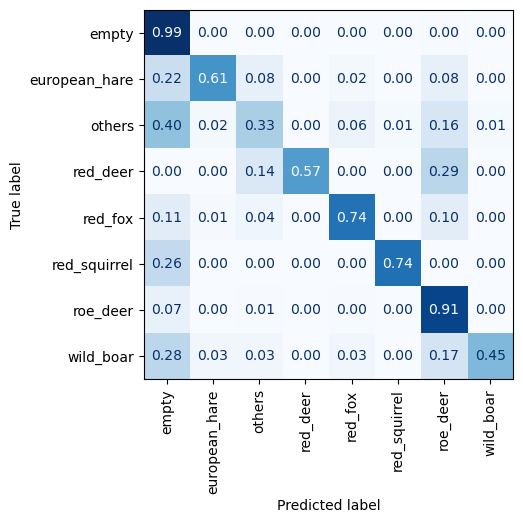

In [242]:
result_ours = [load_pickle(f) for f in FILES_INSAMPLE[1]]
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for rt in results_t:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
classification_report(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds),
    target_names=list(LABEL_MAP.keys()),
)
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)
# conf_mat = confusion_matrix(np.array(y_true), y_pred)
# reports.append(report)
# conf_matrices.append(conf_mat)
# for rt in results_t:
#     preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
#     y_true = truth_imgs_ppl_t
#     y_pred = [np.argmax(v) for v in preds_imgs_ppl_t]
#     report = classification_report(
#         y_true=y_true, 
#         y_pred=y_pred,
#         target_names=list(LABEL_MAP.keys()),
#         output_dict=True
#     )
#     conf_mat = confusion_matrix(np.array(y_true), y_pred)
#     reports.append(report)
#     conf_matrices.append(conf_mat)
# reports_avg = dict_mean(reports)
# conf_mat_avg = np.round(reduce(sum, conf_matrices) / len(conf_matrices))
# print(report)  # Figure 3
# ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

# OUT-OF-SAMPLE

## PERFORMANCE

In [243]:
FILES_OOSAMPLE

['/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments/results/50/202303160957_oosample_123.pkl',
 '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments/results/50/202303160957_oosample_456.pkl',
 '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments/results/50/202303160957_oosample_789.pkl']

In [244]:
result_ours = [load_pickle(f) for f in FILES_OOSAMPLE]
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for rt in results_t:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
report_dict = classification_report(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds),
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
rows = []
rows.append(
    [
        report_dict['accuracy'], 
        report_dict['weighted avg']['precision'], 
        report_dict['weighted avg']['recall'], 
        report_dict['weighted avg']['f1-score']
    ]
)

In [6]:
y_true = results_oosample_avg['truth_imgs_ppl']
y_pred = [np.argmax(v) for v in results_oosample_avg['preds_imgs_ppl']]
report_dict = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
rows = []
rows.append(
    [
        report_dict['accuracy'], 
        report_dict['weighted avg']['precision'], 
        report_dict['weighted avg']['recall'], 
        report_dict['weighted avg']['f1-score']
    ]
)

In [245]:
acc_al_lower_limit, rec_al_lower_limit = rows[0][0], rows[0][1]

In [246]:
df_oos_multiclass = pd.DataFrame(
    rows,
    columns=['acc', 'prec', 'rec', 'fone']
)
df_multiclass = pd.concat([df_ins_multiclass.loc[df_ins_multiclass['threshold'] == OUR_THRESH], df_oos_multiclass])
df_multiclass.index = ['ins', 'oos']

In [247]:
df_multiclass.drop(['threshold'], axis=1)  # Table 5

,acc,prec,rec,fone
ins,0.928337,0.924400,0.928337,0.924822
oos,0.923414,0.916757,0.923414,0.916495


               precision    recall  f1-score   support

        empty       0.93      0.99      0.96      7086
european_hare       0.85      0.61      0.71       192
       others       0.67      0.33      0.44       432
     red_deer       1.00      0.57      0.73        21
      red_fox       0.83      0.74      0.78       297
 red_squirrel       0.90      0.74      0.81       141
     roe_deer       0.94      0.91      0.92      2712
    wild_boar       0.68      0.45      0.54        87

     accuracy                           0.92     10968
    macro avg       0.85      0.67      0.74     10968
 weighted avg       0.92      0.92      0.92     10968



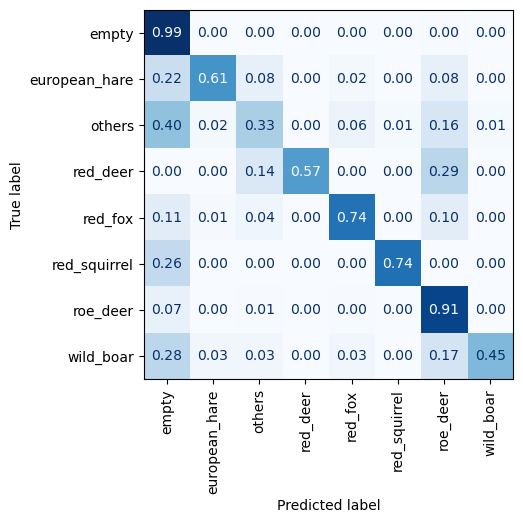

In [249]:
print(  # Figure 5
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

## ACTIVE LEARNING

In [8]:
RESULTS_ACTIVE = results_active_optimal_avg
y_true = RESULTS_ACTIVE['truth_imgs_ppl']
y_pred = [np.argmax(v) for v in RESULTS_ACTIVE['preds_imgs_ppl']]
report_dict = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
acc_al_upper_limit, rec_al_upper_limit = report_dict['accuracy'], report_dict['weighted avg']['precision']

               precision    recall  f1-score   support

        empty       0.94      0.98      0.96      2138
european_hare       1.00      0.62      0.77        37
       others       0.85      0.38      0.52       159
     red_deer       0.71      0.42      0.53        12
      red_fox       0.93      0.76      0.84        17
 red_squirrel       1.00      1.00      1.00         2
     roe_deer       0.91      0.94      0.92      1042
    wild_boar       0.96      0.82      0.89       156

     accuracy                           0.93      3563
    macro avg       0.91      0.74      0.80      3563
 weighted avg       0.93      0.93      0.92      3563



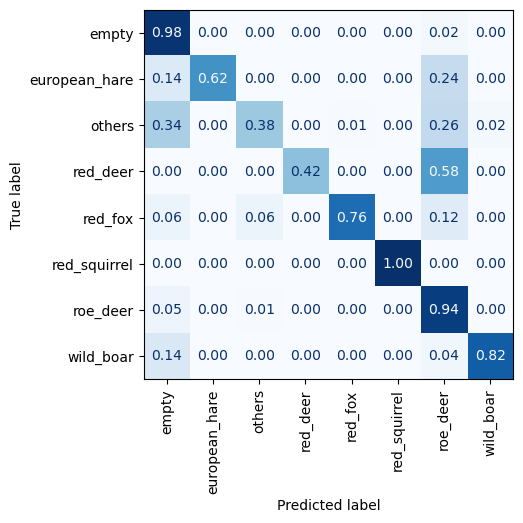

In [9]:
print(  # Figure 5
    classification_report(
        y_true=RESULTS_ACTIVE['truth_imgs_ppl'], 
        y_pred=[np.argmax(v) for v in RESULTS_ACTIVE['preds_imgs_ppl']],
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

In [37]:
# compute relative sample size per iteration (sizes hard-coded for training)
n_obs = 23491
init_batches = [2**x for x in range(7, 14)]
batch_sizes = init_batches + [n_obs - sum(init_batches)]
batch_sizes_cs = np.cumsum([x / n_obs for x in batch_sizes])

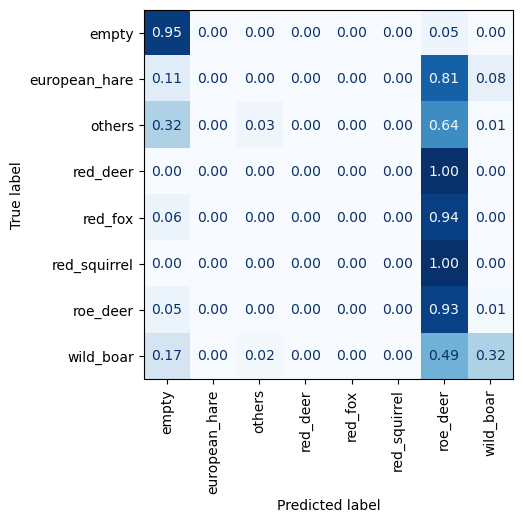

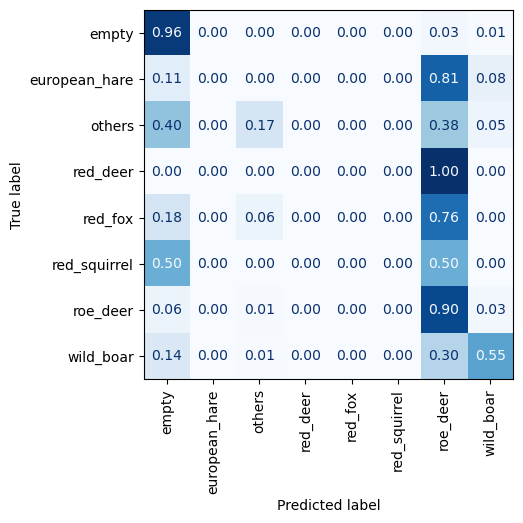

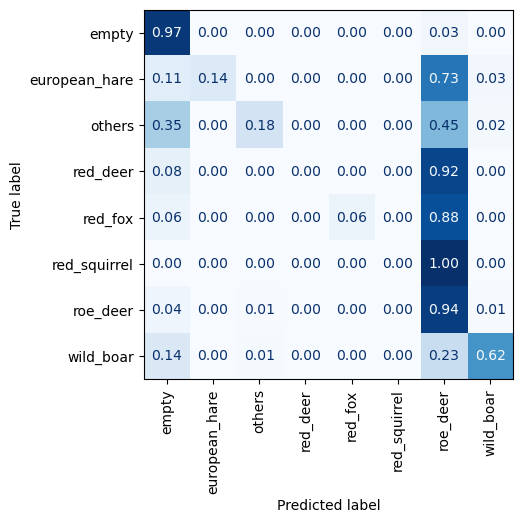

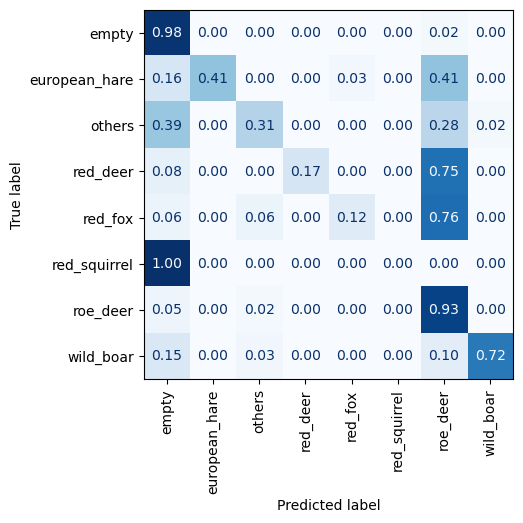

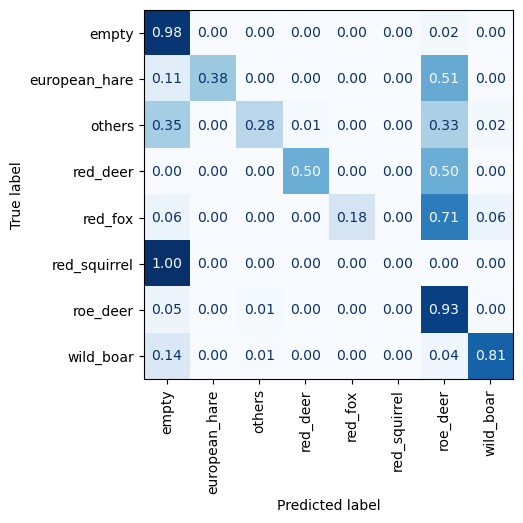

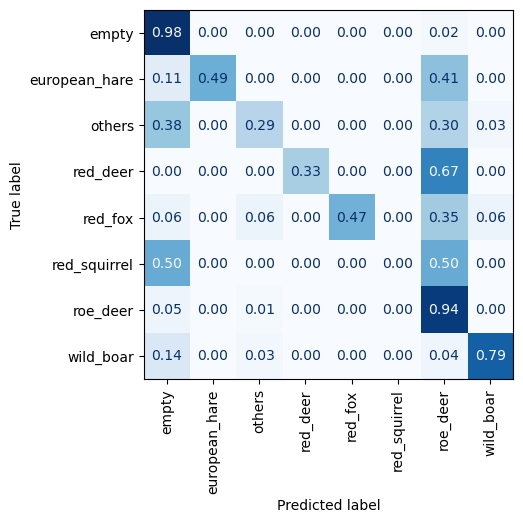

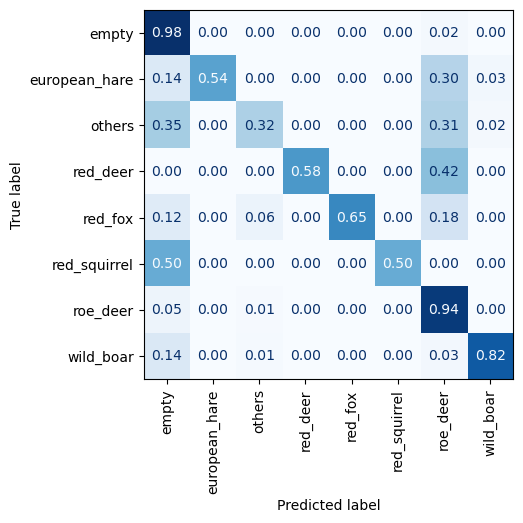

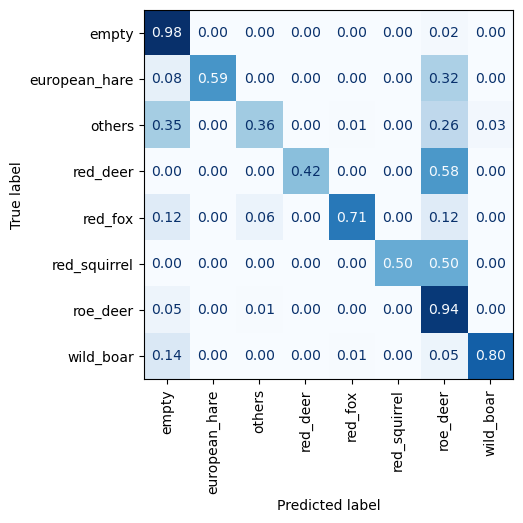

In [38]:
RESULTS_ACTIVE_CS = results_active_coldstart_avg
acc_coldstart, rec_coldstart = [], []
# acc_warmstart, rec_warmstart = [], []

for i in ITERATIONS:
    y_true_cs = RESULTS_ACTIVE_CS[i]['truth_imgs_ppl']
    y_pred_cs = [np.argmax(v) for v in RESULTS_ACTIVE_CS[i]['preds_imgs_ppl']]
    report_dict_cs = classification_report(
        y_true=y_true_cs, 
        y_pred=y_pred_cs,
        target_names=list(LABEL_MAP.keys()),
        output_dict=True,
        zero_division=0
    )
    ConfusionMatrixDisplay.from_predictions(y_true=y_true_cs, y_pred=y_pred_cs, **CONFMAT_ARGS)
    #     y_true_ws = results_active_warmstart_avg[i]['truth_imgs_ppl']
#     y_pred_ws = [np.argmax(v) for v in results_active_warmstart_avg[i]['preds_imgs_ppl']]
#     report_dict_ws = classification_report(
#         y_true=y_true_ws, 
#         y_pred=y_pred_ws,
#         target_names=list(LABEL_MAP.keys()),
#         output_dict=True,
#         zero_division=0
#     )
    acc_coldstart.append(report_dict_cs['accuracy'])
    rec_coldstart.append(report_dict_cs['weighted avg']['recall'])
#     acc_warmstart.append(report_ws['accuracy'])
#     rec_warmstart.append(report_ws['weighted avg']['recall'])

In [42]:
acc_coldstart[-1] = acc_al_upper_limit
rec_coldstart[-1] = rec_al_upper_limit

In [43]:
# create data for plot
al_perf_acc = {
    'relative_size': batch_sizes_cs,
    'acc_lower_limit': [acc_al_lower_limit for _ in range(len(acc_coldstart))],
    'acc_upper_limit': [acc_al_upper_limit for _ in range(len(acc_coldstart))],
    'acc_coldstart': acc_coldstart,
#     'acc_warmstart': acc_warmstart
}
al_perf_rec = {
    'relative_size': batch_sizes_cs,
    'rec_lower_limit': [rec_al_lower_limit for _ in range(len(acc_coldstart))],
    'rec_upper_limit': [rec_al_upper_limit for _ in range(len(acc_coldstart))],
    'rec_coldstart': rec_coldstart,
#     'rec_warmstart': rec_warmstart
}
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
al_perf_rec_pd = pd.DataFrame(al_perf_rec)

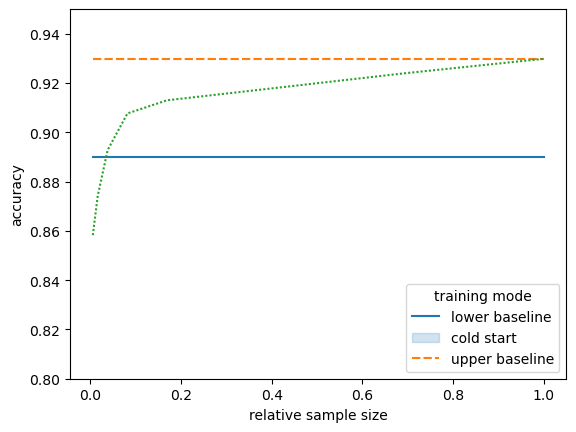

In [44]:
plt = sns.lineplot(
    data=pd.melt(al_perf_acc_pd, id_vars='relative_size'),
    x='relative_size',
    y='value',
    hue='variable',
    style='variable'
)
plt.set(xlabel='relative sample size', ylabel='accuracy', ylim=(0.8, 0.95))
# plt.ylim(0.5, 1)
plt.legend(
    title='training mode', 
    loc='lower right', 
    labels=['lower baseline', 'cold start', 'upper baseline']  # , 'warm start']
)